# Samples analysis
Analysis of posterior samples

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.30' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from numpy.testing import assert_allclose
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

## Import

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_loc, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_shape=64*np.ones(3, dtype=int), box_size=256*np.ones(3))
config.update(a_lpt=0.1, mesh_shape=64*np.ones(3, dtype=int), fourier=True)
# config.update(a_lpt=0.5, mesh_shape=64*np.ones(3, dtype=int), fourier=False)
model = partial(pmrsd_model, **config)
print_config(model)
expe_prefix = "fourier_pm_"

# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_loc(model)))
fiduc_trace = get_simulator(fiduc_model)(rng_seed=0)
fiduc_lat = param_fn(**fiduc_trace)
fiduc_lat_ = param_fn(inverse=True, **fiduc_lat)

# Chain init
@jit
@vmap
def sample_init_chains(rng_key, scale_std):
    params_ = seed(prior_model, rng_key)(**config)
    params = get_param_fn(scale_std=scale_std, **config)(**params_)
    return get_param_fn(**config)(inverse=True, **params)

# init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array(7*[1/10]))
# init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), fiduc_params_, init_params_)
init_params_ = tree_map(lambda x: jnp.tile(x, (8,*len(jnp.shape(x))*[1])), fiduc_lat_)
pickle_dump(fiduc_trace, save_dir + expe_prefix + "fiduc_trace.p")
pickle_dump(init_params_, save_dir + expe_prefix + "init_params_.p")

# Load fiducial and chain init params
# fiduc_params = pickle_load(save_dir + expe_prefix + "fiduc_params.p")
# init_params_ = pickle_load(save_dir + expe_prefix + "init_params_.p")

# Condition model on observables
obs_names = ['obs']
# obs_names = ['obs','b1_','b2_','bs2_','bn2_']
# obs_names = ['obs','Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_']
obs_params = {name: fiduc_trace[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)

2024-07-23 10:06:21.249723: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# CONFIG
{'mesh_shape': array([64, 64, 64]), 'box_shape': array([640., 640., 640.]), 'a_lpt': 0.1, 'a_obs': 0.5, 'lpt_order': 1, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0], 'init_mesh': ['{\\delta}_L', None, None]}, 'fourier': True, 'lik_config': {'obs_std': 1.0, 'obs': 'mesh', 'multipoles': [0, 2, 4]}}

# INFOS
cell_shape:     [10.0, 10.0, 10.0] Mpc/h
dk:             0.00982 h/Mpc
k_nyquist:      0.31416 h/Mpc
mean_gxy_count: 1.000 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [3]:
print(fiduc_trace.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['b1_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs']) 
 [-0.13291842 -0.13291842 -0.13291842 -0.13291842 -0.13291842 -0.13291842
 -0.13291842 -0.13291842] 
 [0. 0. 0. 0. 0. 0. 0. 0.] 
 [0.91338354 0.91338354 0.91338354 0.91338354 0.91338354 0.91338354
 0.91338354 0.91338354]


In [6]:
print(fiduc_trace.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['b1_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs']) 
 [-0.13291842 -0.13291842 -0.13291842 -0.13291842 -0.13291842 -0.13291842
 -0.13291842 -0.13291842] 
 [0. 0. 0. 0. 0. 0. 0. 0.] 
 [0.91338354 0.91338354 0.91338354 0.91338354 0.91338354 0.91338354
 0.91338354 0.91338354]


## Single run analysis

In [16]:
# load_path = save_dir + f"MCLMC/MCLMC_ns8192_x_nc8"
# load_path = save_dir + f"NUTSGibbs/HMCGibbs_ns256_x_nc8"
# load_path = save_dir + f"NUTSGibbs2/NUTSGibbs_ns256_x_nc8"
# load_path = save_dir + f"NUTS/NUTS_ns256_x_nc8"
# load_path = save_dir + f"NUTS_nc8_x_ns128_fourier2"

paths = ["fourier_pm_plk_NUTS_nc10_x_ns64","NUTS_nc8_x_ns64_fourier_pm"]
load_path = [os.path.join(save_dir, path) for path in paths]
start_run, end_run = [1,1], [3,5]
# TODO: make a dict with mclabel:path, start_run, end_run

from montecosmo.mcbench import MCBench
from montecosmo.models import default_config as config, bench_config
bench_config.update(n_cell=0, thinning=1)
# bench_config.update(n_cell=None, thinning=8)
mcbench = MCBench(config, bench_config, fiduc_trace)
samples_ = mcbench.load_chains_(load_path, start_run, end_run)
samples = mcbench.load_chains(load_path, start_run, end_run)
# moments = mcbench.load_moments(load_path, start_run, end_run)

config.update(fourier=False)
mcbench = MCBench(config, bench_config, fiduc_trace)
load_path = save_dir + f"nofourier_pm_NUTS_nc8_x_ns64"
start_run, end_run = 1,3
samples2 = mcbench.load_chains(load_path, start_run, end_run)

samples = [*samples, samples2]
mclabel = ["$P_\\ell$, fourier", "$\\delta_g$, fourier", "$\\delta_g$, spatial"]

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

loading: fourier_pm_plk_NUTS_nc10_x_ns64, from run 1 to run 3 (included)
total n_samples: (10, 192), total n_evals: [48960 24384 48960 48960 24222 48960 48960 24384 48960 48960]

loading: NUTS_nc8_x_ns64_fourier_pm, from run 1 to run 5 (included)
total n_samples: (8, 320), total n_evals: [81600 81600 40640 81600 81600 81600 40640 40640]

loading: fourier_pm_plk_NUTS_nc10_x_ns64, from run 1 to run 3 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (10, 192), total n_evals: [48960 24384 48960 48960 24222 48960 48960 24384 48960 48960]

loading: NUTS_nc8_x_ns64_fourier_pm, from run 1 to run 5 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 320), total n_evals: [81600 81600 40640 81600 81600 81600 40640 40640]



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

loading: nofourier_pm_NUTS_nc8_x_ns64, from run 1 to run 3 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 192), total n_evals: [196416 196416 196416 196416 196416 196416 196416 196416]



### Chain

In [ ]:
# theme_switch()
plt.figure(figsize=(18,5))
mcbench.plot_pk(samples, label=mclabel, proba=[.68,.95,.997])
plt.tight_layout()
# plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

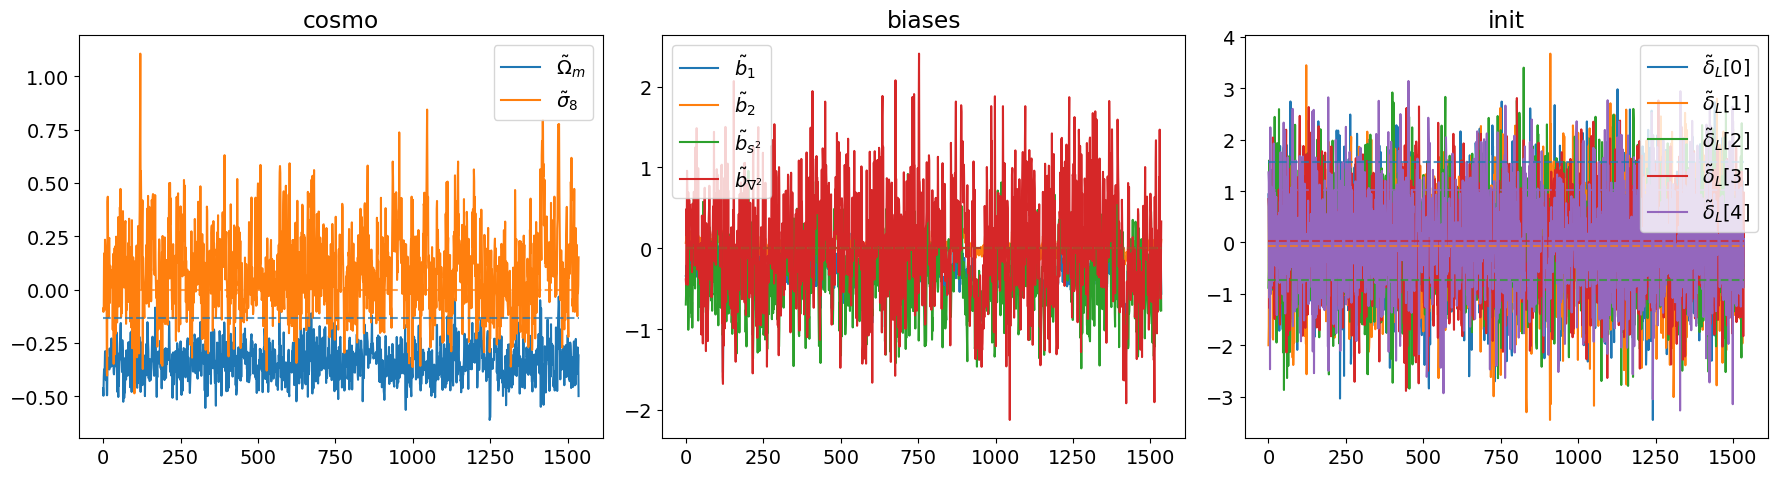

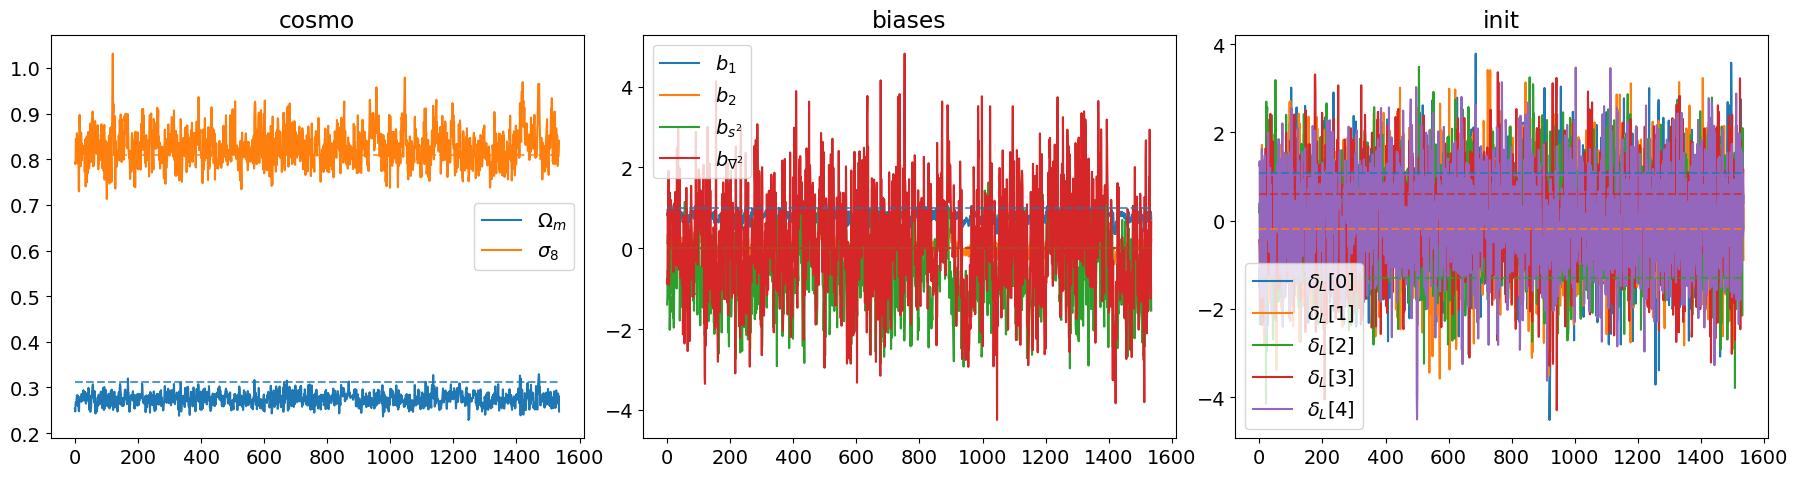

In [7]:
theme_switch(usetex=False, font_size=14)
plt.figure(figsize=(18,5))
mcbench.plot_chains(samples_[0], mcbench.fiduc_)
plt.tight_layout()
plt.figure(figsize=(18,5))
mcbench.plot_chains(samples[0], mcbench.fiduc)
plt.tight_layout()

Removed no burn in
# $P_\ell$, fourier
using 1920 rows, 6 parameters; mean weight 1.0, tot weight 1920.0
Equiv number of single samples (sum w)/max(w): 1920
Effective number of weighted samples (sum w)^2/sum(w^2): 1920


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.27      0.02      0.27      0.24      0.29    995.41      1.00
    sigma8      0.83      0.04      0.82      0.76      0.89    758.83      1.00
        b1      0.81      0.10      0.82      0.66      0.98    627.66      1.01
        b2      0.16      0.19      0.16     -0.14      0.47    731.91      1.01
       bs2     -0.60      0.90     -0.62     -2.11      0.81    727.97      1.01
       bn2     -0.35      1.41     -0.42     -2.81      1.78    981.34      1.00

Removed no burn in
# $\delta_g$, fourier
using 2560 rows, 6 parameters; mean weight 1.0, tot weight 2560.0
Equiv number of single samples (sum w)/max(w): 2560
Effective number of weighted samples (sum w)^2/sum(w

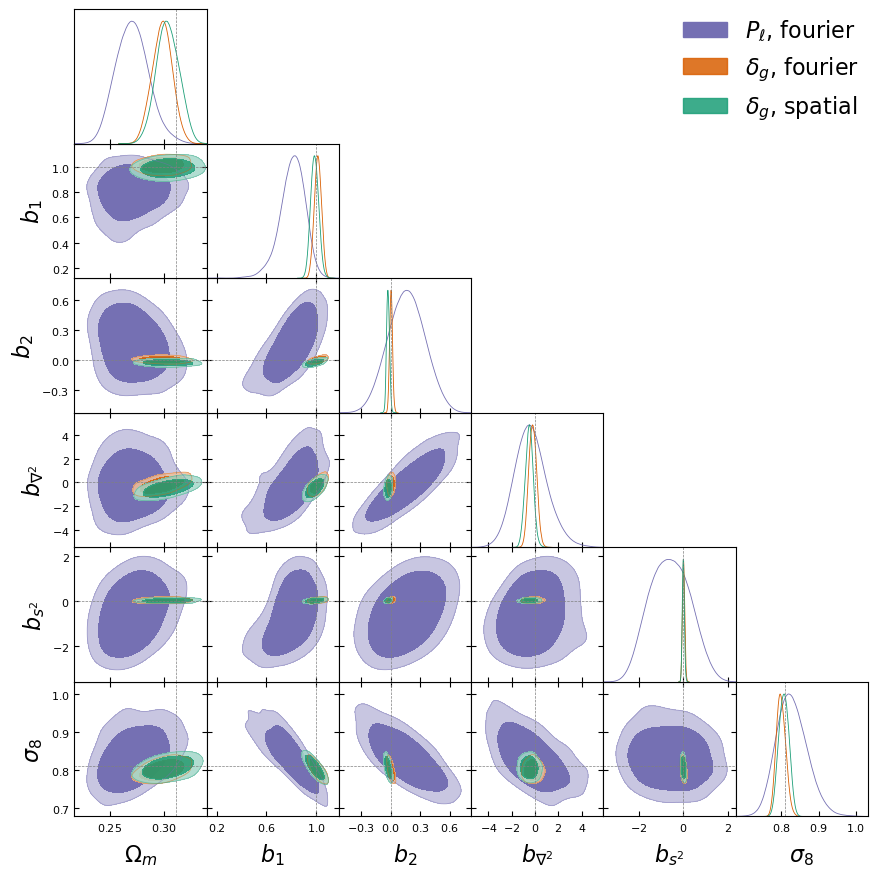

In [23]:
%matplotlib inline
gdsamples = mcbench.get_gdsamples(samples, label=mclabel, verbose=True)
for i_gds, gds in enumerate(gdsamples): 
    gdsamples[i_gds] = gds.copy(settings={
                            # 'smooth_scale_2D':1,
                            # 'smooth_scale_1D':1, 
                            'contours':[0.9, 0.99]
                            })
g = plots.get_subplot_plotter(width_inch=9)
g.settings.solid_colors='Dark2'
g.settings.fontsize = 100
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 12
g.settings.figure_legend_frame = False
g.settings.num_plot_contours = 3
g.triangle_plot(roots=gdsamples, 
                # title_limit=1, 
                filled=True, 
                markers=mcbench.ffiduc,
                # contour_colors=[plt.get_cmap('Dark2')(i/7) for i in range(3)][::-1],
                legend_loc='upper right',) 
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

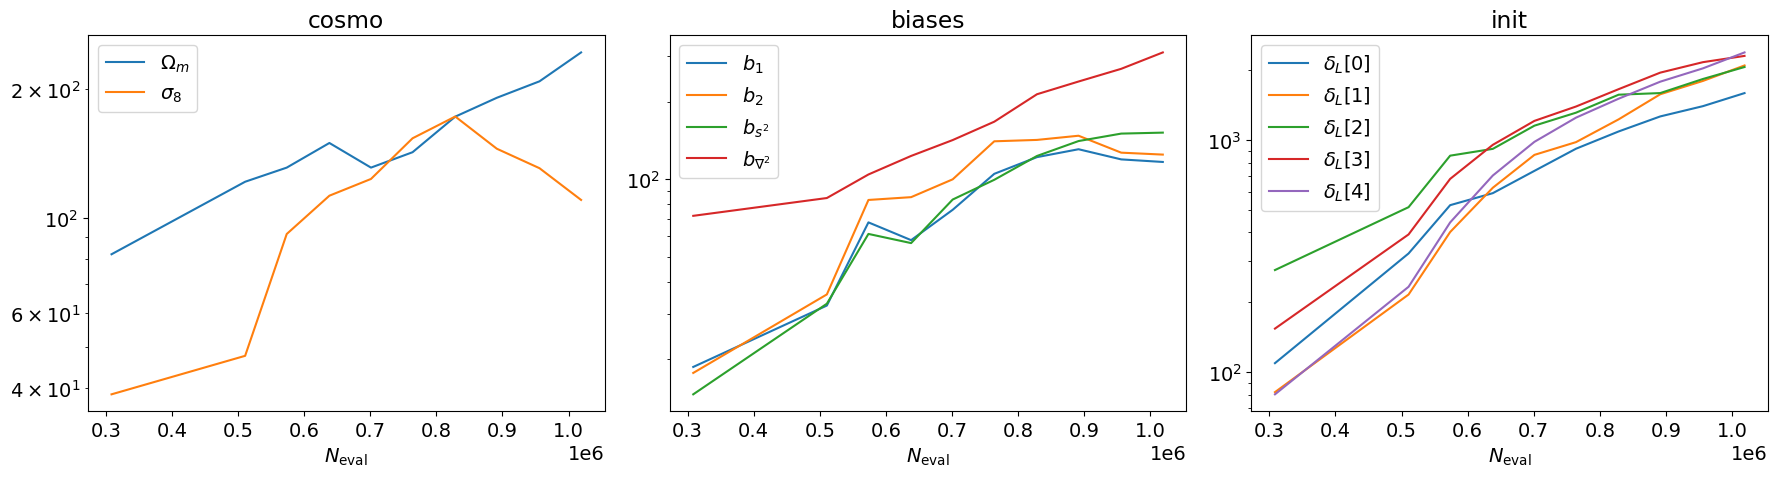

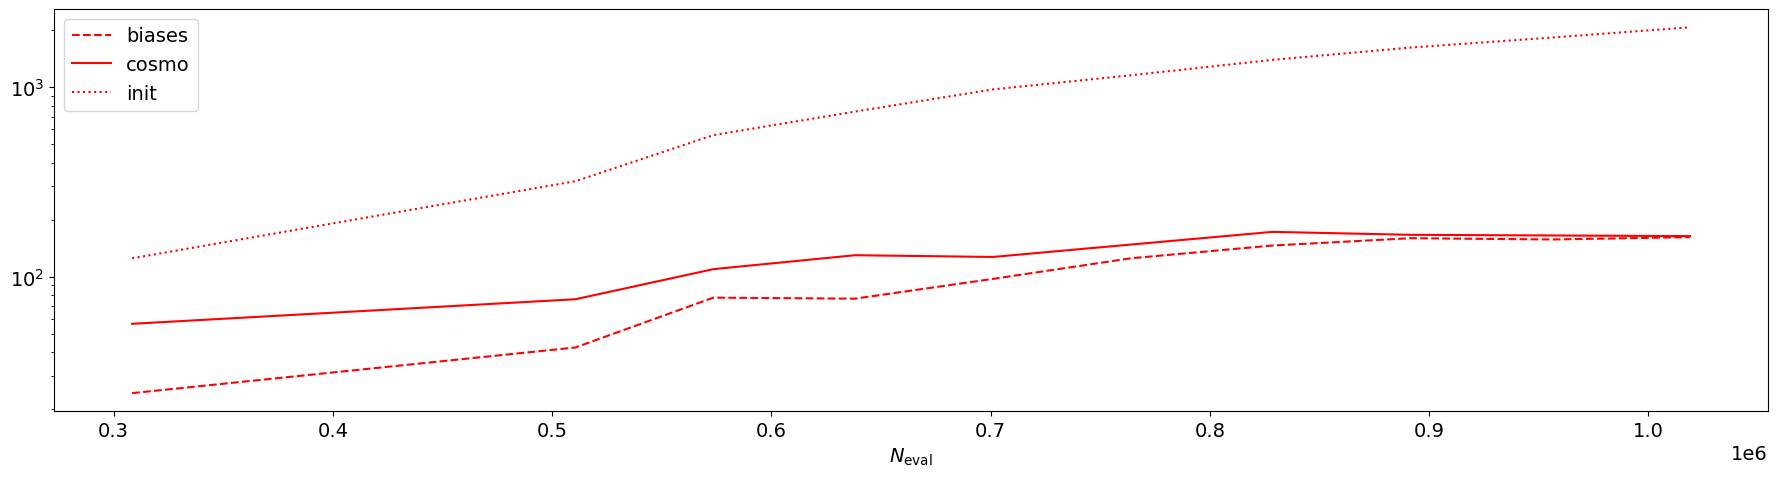

In [18]:
theme_switch(usetex=False, font_size=14)

from montecosmo.metrics import multi_ess, multi_gr

plt.figure(figsize=(18,5))
mess = mcbench._metric_traj(partial(multi_ess, axis=()), samples, n=10)
mcbench.plot_traj(mess, comb=False)
plt.tight_layout()

plt.figure(figsize=(18,5))
mess = mcbench._metric_traj(multi_ess, mcbench.recombine_latent(samples), n=10)
mcbench.plot_traj(mess, c='r', ls=['--', '-', ':', '-.'])
plt.tight_layout()

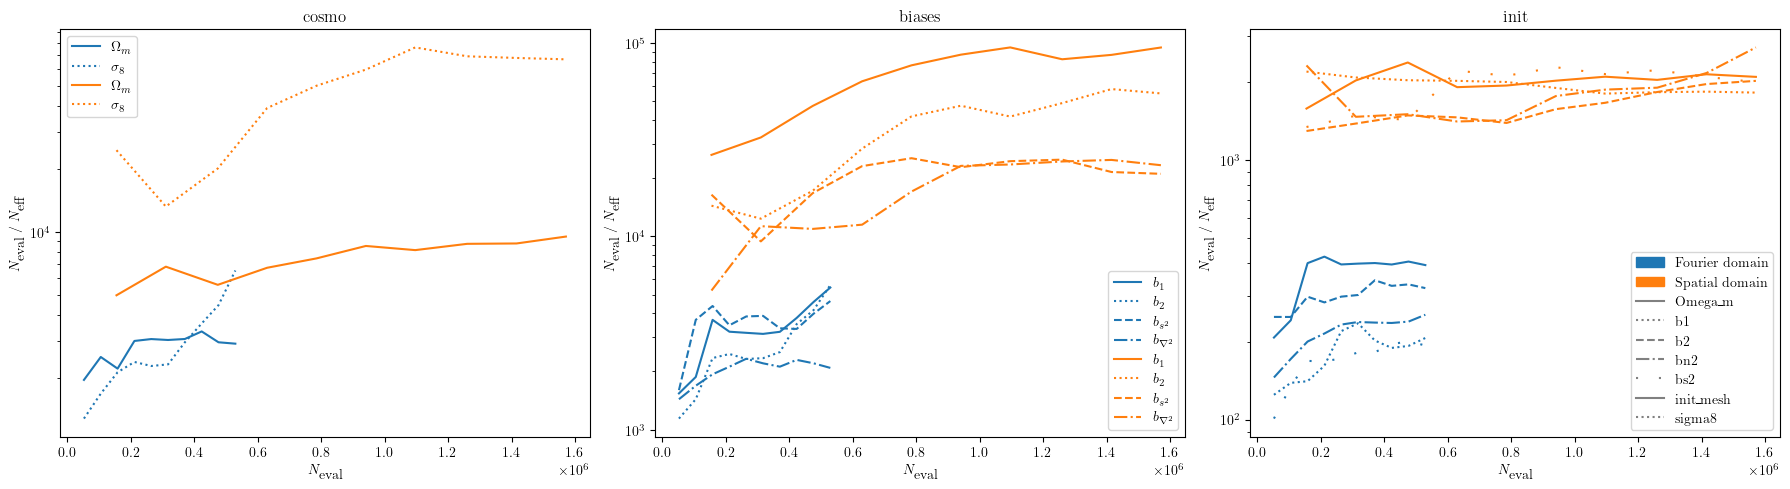

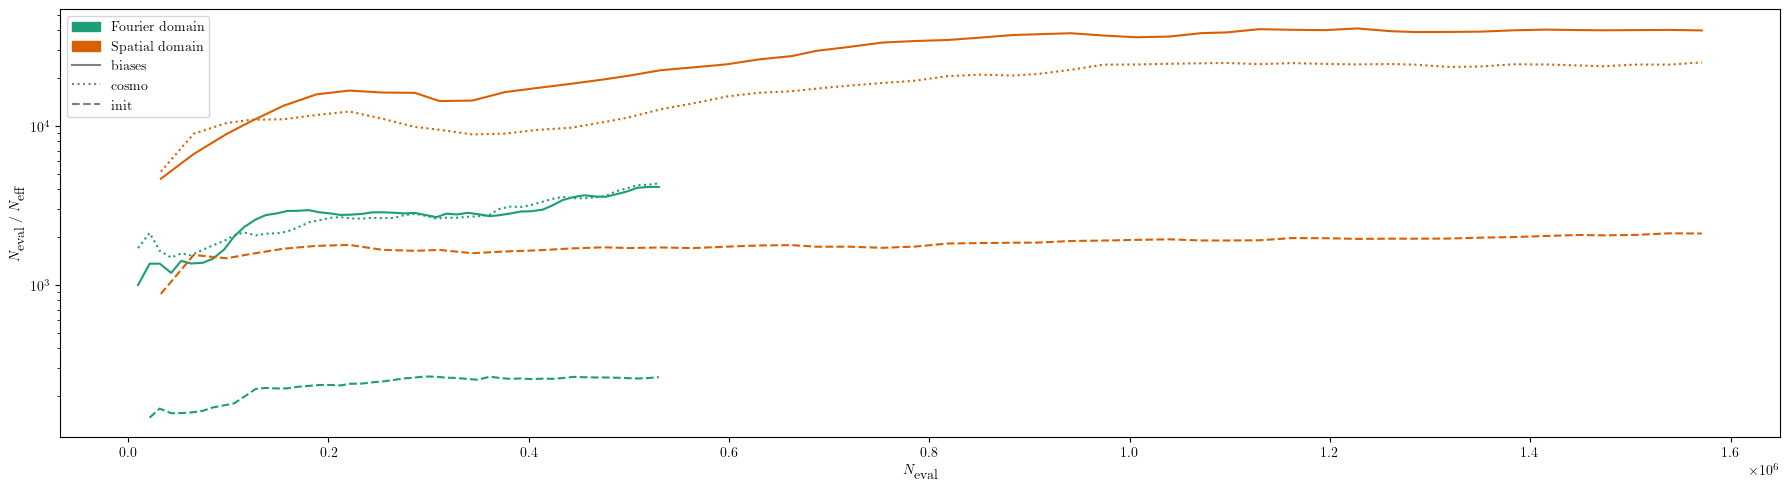

In [67]:
plt.figure(figsize=(18,5))
mcbench.plot_metric_traj("ess", samples, label=mclabel, n=10, comb=False)
plt.tight_layout()

plt.figure(figsize=(18,5))
mcbench.plot_metric_traj("ess", samples, label=mclabel, n=50, comb=True, cmap='Dark2')
plt.tight_layout()

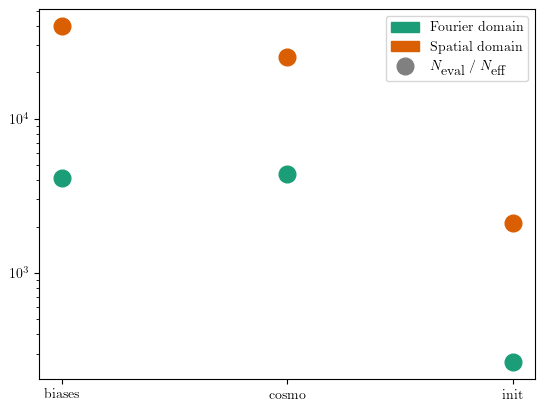

In [66]:
theme_switch(usetex=True)
mcbench.plot_metric_last('ess', samples, label=mclabel, comb=True, cmap='Dark2')

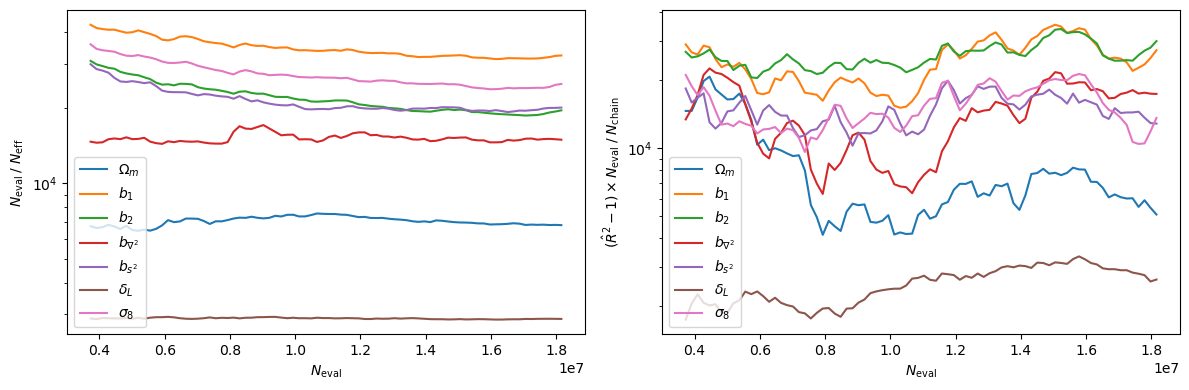

In [ ]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj, infos_traj = separate(ESSs)
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

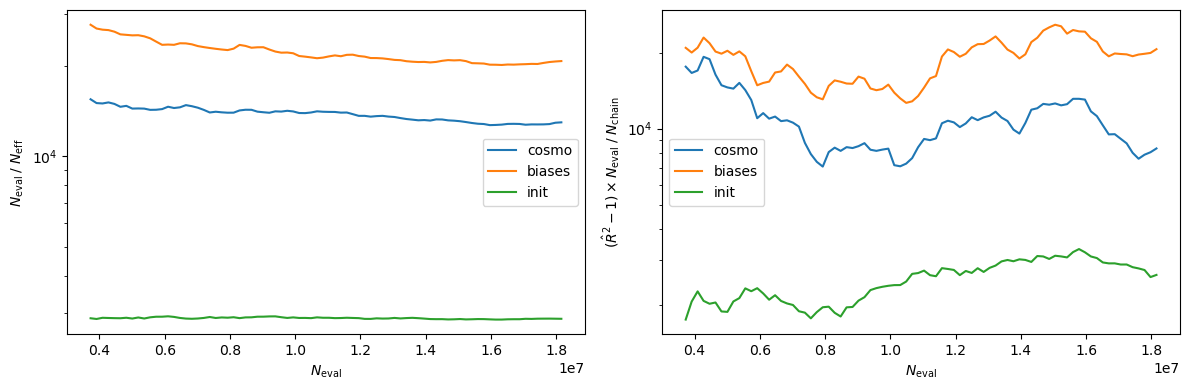

In [ ]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj, infos_traj = separate(ESSs)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(geomean, axis=0))
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        # aggr_fn=partial(grmean, axis=0))
                        aggr_fn=partial(geomean, axis=0))
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

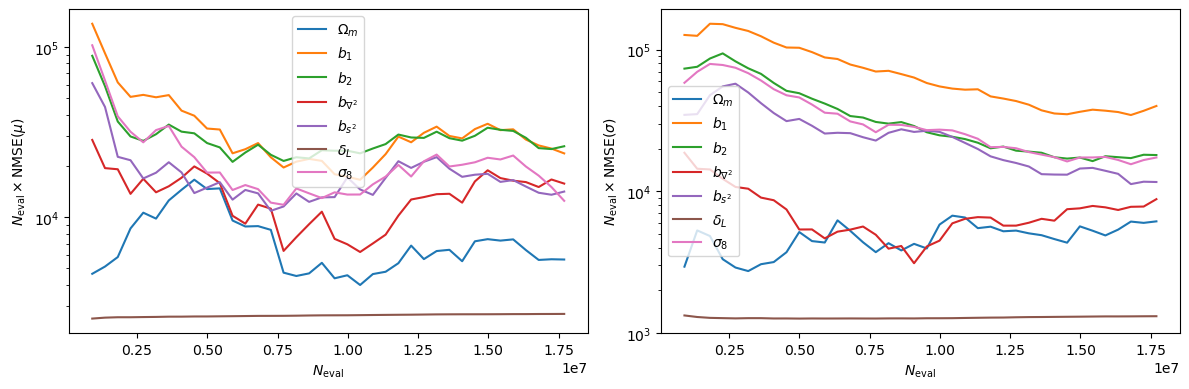

In [40]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :
    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        if name == 'init_mesh':
            label = "$\\delta_L$"
        else:
            label = '$'+config['prior_config'][name][0]+'$'
        plot_fn(val, label=label)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

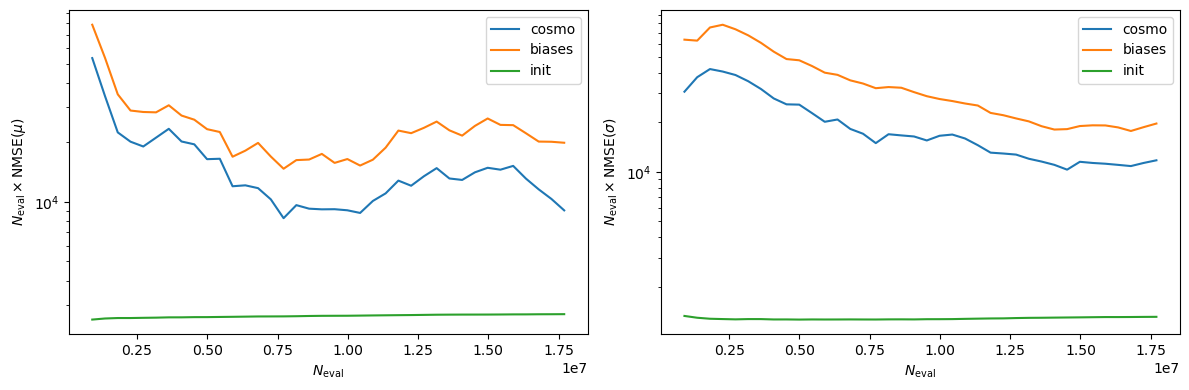

In [44]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(jnp.mean, axis=0))
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        plot_fn(val, label=name)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

## Multiple runs analysis

In [44]:
paths = ["HMC/HMC_ns256_x_nc8","NUTS/NUTS_ns256_x_nc8","NUTSGibbs2/NUTSGibbs_ns256_x_nc8"]
load_paths = np.array([os.path.join(save_dir, path) for path in paths])
mc_labels = ["HMC","NUTS","NUTSGibbs"]
# start_run, end_run = [2,1,2,1], [64,20,32,20]
start_run, end_run = [2,1,7], [64,20,20]
# start_run, end_run = [1,1,1], [5,5,5]

# moments = load_moments(load_paths, start_run, end_run)

# samples_ = load_chains_(load_paths, start_run, end_run)
samples = load_chains(load_paths, start_run, end_run)
# samples = [jit(vmap(param_fn))(**s_) | separate(s_)[1] for s_ in samples_]

loading: HMC_ns256_x_nc8, from run 2 to run 64 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 16128), total n_evals: [3306240 3935232 4032000 4015872 3935232 3741696 2919168 2709504]

loading: NUTS_ns256_x_nc8, from run 1 to run 20 (included)
total n_samples: (8, 5120), total n_evals: [5237760 5237760 5237760 5237760 5237760 5237760 5237760 5237760]

loading: NUTSGibbs_ns256_x_nc8, from run 7 to run 20 (included)
total n_samples: (8, 3584), total n_evals: [3719620 3714302 3707724 3718660 3707108 3713154 3710462 3706174]



In [5]:
paths = ["NUTS_nc8_x_ns64_fourier_pm","NUTS_nc8_x_ns64_fourier_pm_pk"]
load_paths = np.array([os.path.join(save_dir, path) for path in paths])
mc_labels = ["Field-level","Power spectrum"]
start_run, end_run = [0,0], [5,2]

# moments = load_moments(load_paths, start_run, end_run)

# samples_ = load_chains_(load_paths, start_run, end_run)
samples = load_chains(load_paths, start_run, end_run)
# samples = [jit(vmap(param_fn))(**s_) | separate(s_)[1] for s_ in samples_]

loading: NUTS_nc8_x_ns64_fourier_pm, from run 0 to run 5 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 384), total n_evals: [142033 143232 100766 143232 142507 143744 101696 101824]

loading: NUTS_nc8_x_ns64_fourier_pm_pk, from run 0 to run 2 (included)
total n_samples: (8, 192), total n_evals: [60277 55896 61868 61612 61748 59467 62191 46822]



In [ ]:
n_toplot = 200
ESSs = [get_metric_traj(multi_ess_fn, s, n_toplot, 1) for s in samples]
GRs = [get_metric_traj(multi_gr_fn2, s, n_toplot, 1) for s in samples]
moments_true = pickle_load(save_dir+"NUTS/NUTS_moments20.p")
# NMSEs = [get_metric_traj(sqrerr_locscale_fn, m, n_toplot, 0, moments_true) for m in moments]
NMSEs = [get_metric_traj(sqrerr_locscale_fn2, m, n_toplot, 0, moments_true) for m in moments]

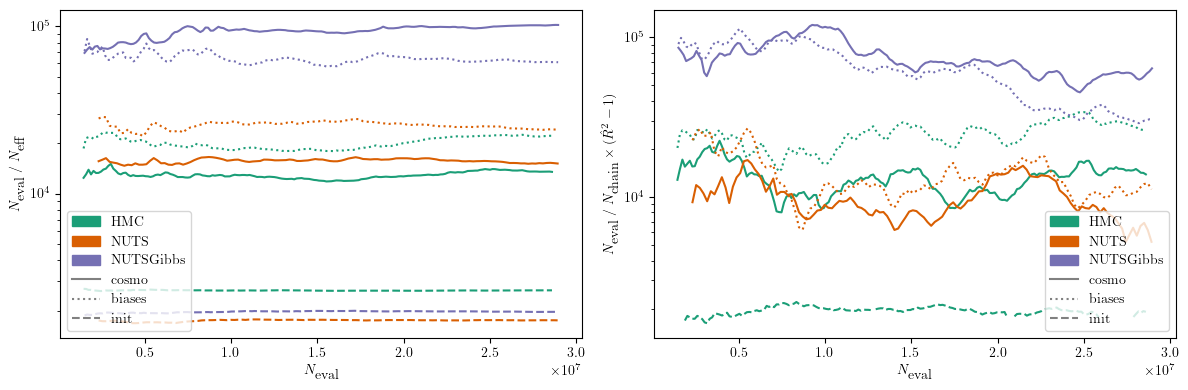

In [35]:
sli_plot = slice(10,None)
sli_plots = len(samples) * [sli_plot]
sli_plots = [slice(10,None), slice(10,2*68), slice(10,195)]
# sli_plots = [slice(2*15,None), slice(2*10,2*68), slice(2*8,2*53)]
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']
recomb_cbi = partial(recombine, 
					 block=[['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
					 block_name=['cosmo','biases','init']) 

plt.figure(figsize=(12,4))
plt.subplot(121)
trajs = []
for m in ESSs: # TODO: modify to not do for loop but instead tree_map and first dim is sampler dim
    traj = recomb_cbi(m, aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)

theme_switch(usetex=True)
# plt.subplot(1, 2, 1)
for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles, loc="lower left")




plt.subplot(1, 2, 2)
trajs = []
for m in GRs:
    traj = recomb_cbi(m, 
                    # aggr_fn=partial(grmean, axis=0))
                      aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)

for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    # plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{chain}} \\times (\\hat R^2 - 1)$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles)
plt.tight_layout()
# plt.savefig('ess_traj.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

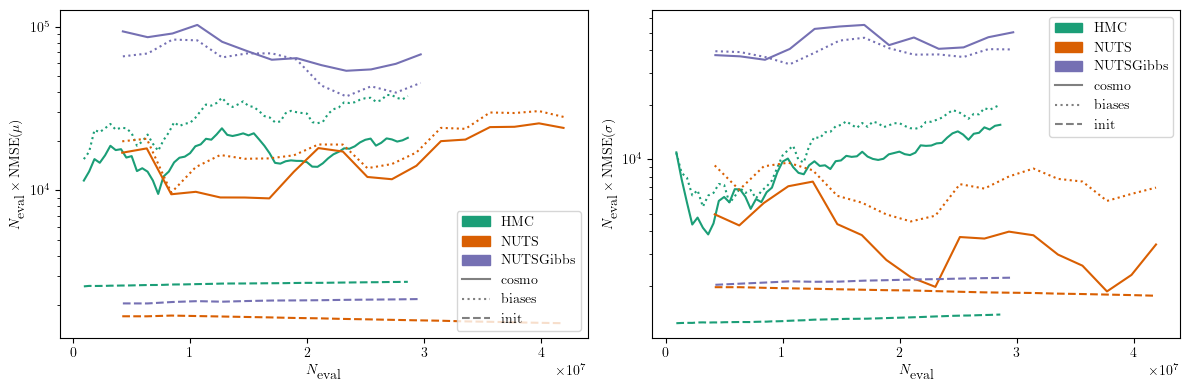

In [36]:
sli_plot = slice(0,None)
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']

trajs = []
for m in NMSEs:
    traj = recomb_cbi(m, aggr_fn=partial(jnp.mean, axis=0))
    trajs.append(traj)

plt.figure(figsize=(12,4))
for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    # markers = ['+','^']
    plt.subplot(1, 2, i_plot+1)
    markers = 2*[None]

    for i_traj, traj in enumerate(trajs):
        metrics, infos = separate(traj)
        num_steps = infos['num_steps']
        # if i_traj ==2: print(num_steps)

        plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
        for i_val, (name, val) in enumerate(metrics.items()):
            plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val], marker=markers[i_plot])

    # plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}} \\times \\textrm{NMSE}("+name_stat+")$")
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    # handles, labels = plt.gca().get_legend_handles_labels()
    handles = []
    for i_traj in range(len(trajs)):
        handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
    for i_val, name in enumerate(metrics):
        handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
    plt.legend(handles=handles)
plt.tight_layout()
plt.show();

In [37]:
def get_first_after(dic, thres, verbose=False, mult=True):
	metrics, infos = separate(dic)
	num_steps = infos['num_steps']
	i_thres = (num_steps > thres).argmax(axis=0)
	ns = num_steps[i_thres]
	if verbose:
		print(f"relerr: {(ns - thres)/thres:.0e}")
	if mult:
		return tree_map(lambda x: ns * x[i_thres], metrics)
	else:
		return tree_map(lambda x: ns / x[i_thres], metrics)


# thres = 2.8*1e7
thres = 2.5*1e7
ESS1 = [recomb_cbi(get_first_after(m, thres, True, False), aggr_fn=partial(geomean, axis=0)) for m in ESSs]
NMSE1 = [recomb_cbi(get_first_after(m, thres, True), aggr_fn=partial(jnp.mean, axis=0)) for m in NMSEs]
metric1 = [tree_map(lambda x,y: jnp.concatenate((x[None], y)), m1, m2) for m1, m2 in zip(ESS1, NMSE1)]

relerr: 2e-04
relerr: 4e-03
relerr: 3e-03
relerr: 2e-02
relerr: 6e-03
relerr: 2e-02


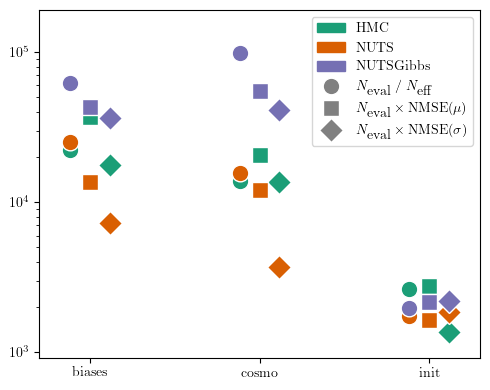

In [38]:
plt.figure(figsize=(5,4))
colors = [plt.get_cmap('Dark2')(i/7) for i in range(len(mc_labels))]
markers = ['o','s','D']
ls = ""
alpha = 1
# ms = 10
# mec = None
ms = 12
mec = 'w'
from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData



usetex = True
theme_switch(usetex=usetex)
for i_mc, (label, mets) in enumerate(zip(mc_labels, metric1)):
    for i_met in range(3):
        # block_names = ['cosmo','biases','init']
        block_names = ['biases','cosmo','init']
        # block_names_lat = ["$\\textrm{biases}$",'$\\textrm{cosmo}$','$\\textrm{init}$']
        met = [mets[k][i_met] for k in block_names]
        if i_met == 0:
            ls = ""
        else:
            ls = ""
        xshifts = 5*np.array([-1,0,1])
        # xshifts = *np.array([0,0,0])
        plt.semilogy(block_names, met, color=colors[i_mc], marker=markers[i_met], 
                     linestyle=ls, alpha=alpha, markersize=ms, markeredgecolor=mec, transform=trans+offset(xshifts[i_met]))

plt.xlim(-.3,2.3), plt.ylim((917, 190842))
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# # handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(mc_labels)):
    # mc_labels_lat = ["$\\textrm{NUTS}$","$\\textrm{HMC}$","$\\textrm{HMCGibbs}$"]
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
if not usetex:
    metric_names = ["$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\mu)$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\sigma)$"]
else:
    metric_names = ["$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\mu)$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\sigma)$"]
for i_met, name in enumerate(metric_names):
    handles.append(Line2D([], [], color='grey', marker=markers[i_met], linestyle=ls, label=name, alpha=alpha, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
# plt.savefig('benchmark.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

### Highest Density Regions

Removed no burn in
# Field-level
using 3072 rows, 6 parameters; mean weight 1.0, tot weight 3072.0
Equiv number of single samples (sum w)/max(w): 3072
Effective number of weighted samples (sum w)^2/sum(w^2): 3072


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.28      0.31    234.19      1.00
        b1      1.01      0.03      1.01      0.97      1.06    120.95      1.00
        b2      0.00      0.01      0.00     -0.02      0.03    131.99      1.00
       bn2     -0.20      0.33     -0.20     -0.73      0.34    310.02      1.00
       bs2      0.02      0.05      0.02     -0.06      0.11    149.99      1.00
    sigma8      0.80      0.01      0.80      0.78      0.82    119.62      1.00

Removed no burn in
# Power spectrum
using 1536 rows, 6 parameters; mean weight 1.0, tot weight 1536.0
Equiv number of single samples (sum w)/max(w): 1536
Effective number of weighted samples (sum w)^2/sum(w^2): 1536



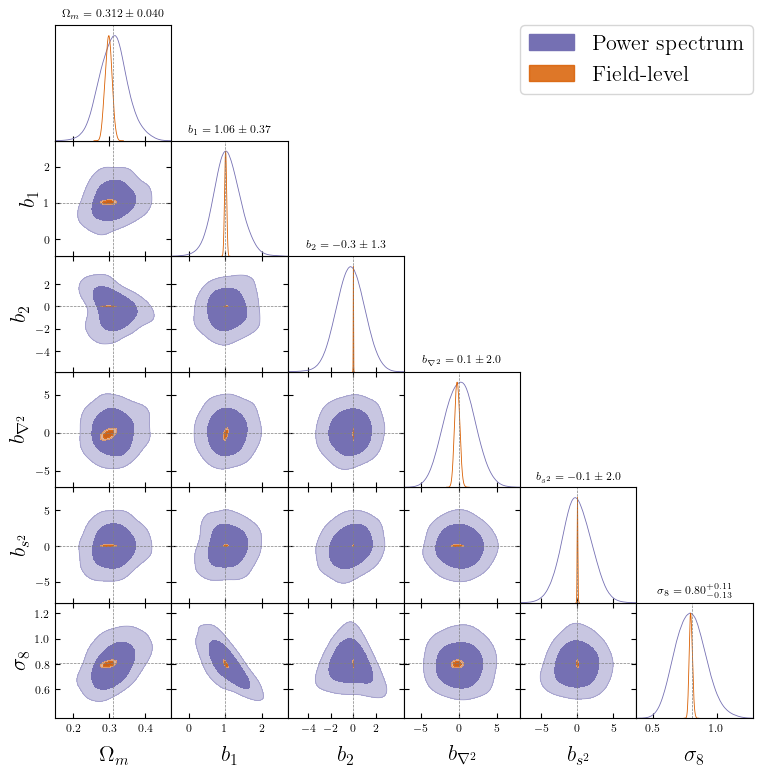

In [7]:
%matplotlib inline
from montecosmo.utils import get_gdsamples

conc_samples = [tree_map(lambda x: jnp.concatenate(x, axis=0), separate(s, ['n_evals','init_mesh'])[0]) for s in samples]
gdsamples = get_gdsamples(conc_samples, label=mc_labels, verbose=True, **config)
# for i_gds, gds in enumerate(gdsamples): 
#     gdsamples[i_gds] = gds.copy(label=mc_labels[i_gds]+", 1$\\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})
# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))

theme_switch(usetex=True)
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r'
g.settings.fontsize = 100
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 12
g.settings.figure_legend_frame = False
g.triangle_plot(roots=gdsamples[::-1], 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                contour_colors=[plt.get_cmap('Dark2')(i/7) for i in range(3)][::-1],
                legend_loc='upper right', 
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
plt.savefig('triangle_bench_field_vs_pk.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


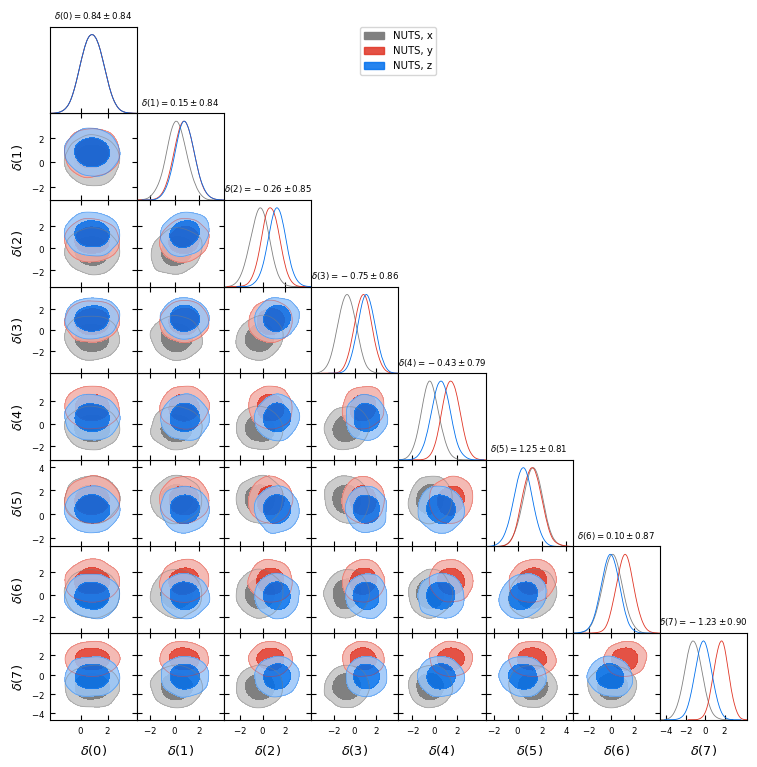

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(load_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


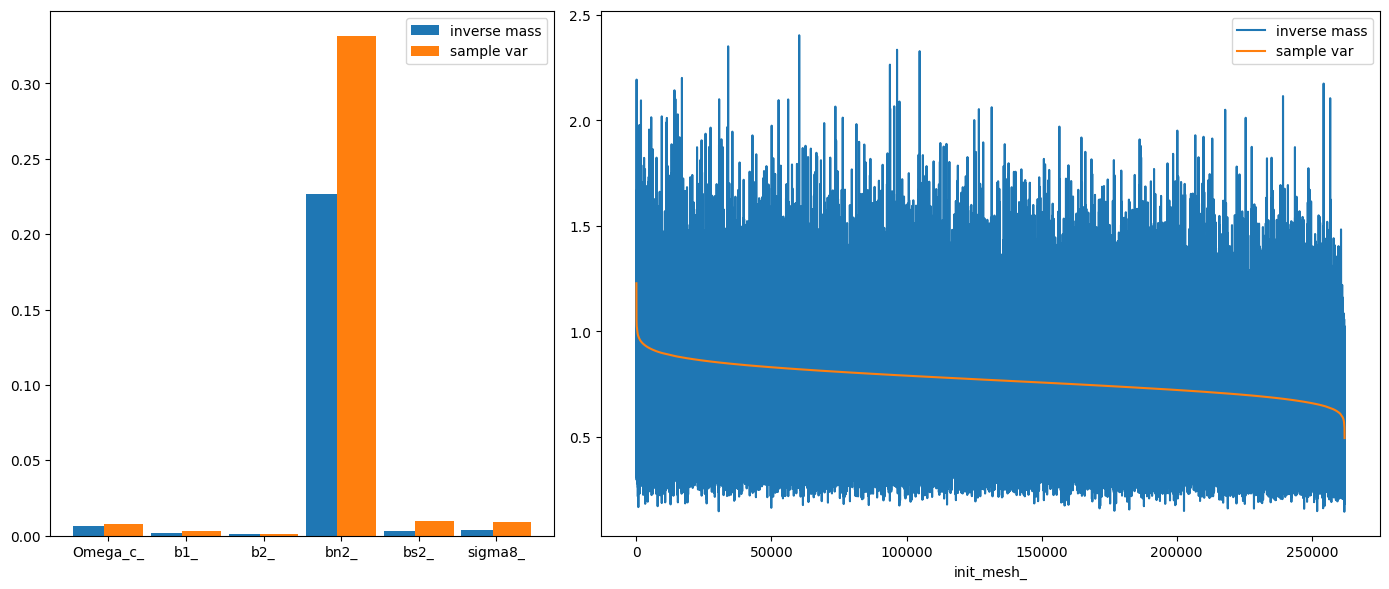

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
# plt.savefig(load_path+"_invMvar.svg");

### Initial field inspection 

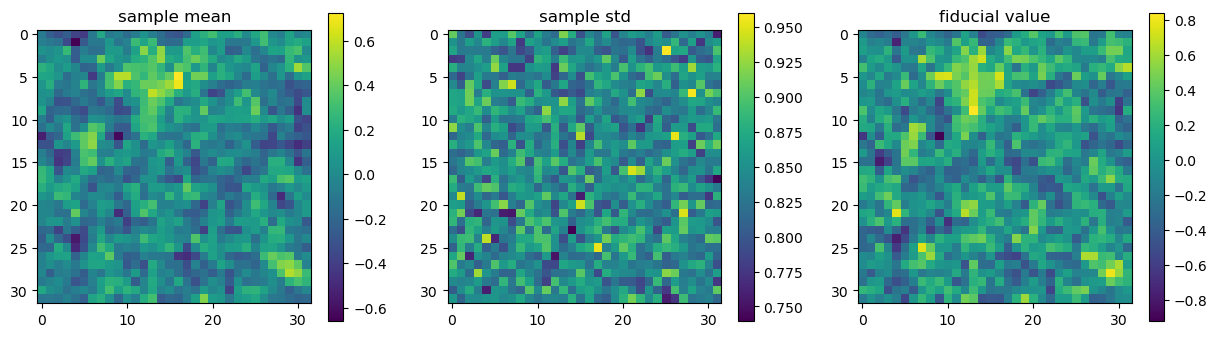

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiduc_params['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();